In [1]:
import osmium
from tqdm import tqdm
from shapely.geometry import Point, LineString
from rtree import index
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import utils.projections as projections

standard_colors = list(mcolors.BASE_COLORS.keys())

In [2]:
# Define a class to handle OSM data parsing
class OSMHandler(osmium.SimpleHandler):
    def __init__(self):
        super(OSMHandler, self).__init__()
        self.hiking_trails = []
        self.lakes = []
        self.trailheads = []

    def way(self, w):
        if 'highway' in w.tags and w.tags['highway'] == 'trailhead':
            if w.location.valid():
                trailhead_meta = {
                    'id': w.id,
                    'name': w.tags['name'] if 'name' in w.tags else '',
                }
                self.trailheads.append((Point(w.location.lat, w.location.lon), trailhead_meta))

        if 'highway' in w.tags and w.tags['highway'] == 'path':
            trail_coords = []
            for n in w.nodes:
                if n.location.valid():
                    trail_coords.append(Point(n.location.lat, n.location.lon))
            if len(trail_coords) > 1:
                trail_line = LineString(trail_coords)
                trail_meta = {
                    'id': w.id,
                    'name': w.tags['name'] if 'name' in w.tags else '',
                }
                self.hiking_trails.append((trail_line, trail_meta))

# Load OSM data using OSMHandler
osm_handler = OSMHandler()
osm_handler.apply_file("data/extract.osm.pbf", locations=True, idx='flex_mem') # use idx=dense_mmap_array for large files on linux

In [3]:
hiking_trails = osm_handler.hiking_trails
print("Number of trails: {}".format(len(hiking_trails)))

Number of trails: 3601


In [4]:
# Create an R-tree index
trail_idx = index.Index()

# Insert lines into the R-tree index with their bounding boxes
for i, (line, _) in enumerate(hiking_trails):
    bbox = line.bounds
    trail_idx.insert(i, bbox)

# Function to find the polygon a line is in (O(log(N)) time complexity)
def find_connecting_trails_for_trail(l, line):
    connected = []
    for i in trail_idx.intersection(line.bounds):
        if i != l:
            # TODO: Consider if need to loosen the intersection if trails don't exactly meet.
            intersection = hiking_trails[i][0].intersection(line)

            cutpoints = []
            if intersection.geom_type == 'Point':
                cutpoints.append(intersection)
            elif intersection.geom_type == 'MultiPoint':
                cutpoints.extend(list(intersection.geoms))

            if not intersection.is_empty:
                connected.append((i, cutpoints))
    return connected

In [5]:
trail_subset = hiking_trails
graph = []
for l, (line, _) in tqdm(enumerate(trail_subset)):
    connections = find_connecting_trails_for_trail(l, line)
    graph.append(connections)

0it [00:00, ?it/s]

3601it [00:00, 10193.77it/s]


In [6]:

def is_along_line(line, point):
    start = Point(line.coords[0])
    end = Point(line.coords[-1])
    return point.intersects(line) or point.equals(start) or point.equals(end)

def get_distance(line, point):
    if line.is_ring: # this path is slow, avoid if possible
        key = (line, point)

        distance = 0
        for i in range(len(line.coords) - 1):
            segment = LineString([line.coords[i], line.coords[i + 1]])
            if is_along_line(segment, point):
                distance += segment.project(point)
                break
            else:
                distance += segment.length
        return distance
    else:
        return line.project(point)

# Break line into segments at cutpoints. Segments are sorted by projection along line.
# Loop has N points and M cutpoints. Total complexity: O(N + MlgM).
def split_trail(trail, cutpoints):
    line = trail[0]
    meta = trail[1]

    start = Point(line.coords[0])
    end = Point(line.coords[-1])

    # O(MlgM)
    uniq_cutpoints = list(set(cutpoints))
    cutpoints_with_distance = [(p, get_distance(line, p)) for p in uniq_cutpoints]
    sorted_cutpoints_along_line = sorted(cutpoints_with_distance, key=lambda x: x[1])

    # Always have end be last with distance of line.
    if len(sorted_cutpoints_along_line) == 0:
        sorted_cutpoints_along_line.append((end, line.length))
    if not end.equals(sorted_cutpoints_along_line[-1][0]):
        sorted_cutpoints_along_line.append((end, line.length))
    else: # last point is end
        sorted_cutpoints_along_line[-1] = (end, line.length)

    linecoords_with_distance = [get_distance(line, Point(p)) for p in line.coords]
    if len(line.coords) > 0 and line.is_ring:
        linecoords_with_distance[-1] = line.length

    # O(N+M)
    sub_lines = []
    prev_cutpoint = start
    line_idx = 0
    for cutpoint, cutpoint_dist in sorted_cutpoints_along_line:
        sub_line = [prev_cutpoint]
        for j, c in enumerate(line.coords[line_idx:]):
            p = Point(c)
            if j == 0:
                if not p.equals(prev_cutpoint):
                    sub_line.append(p)
            else:
                if cutpoint_dist <= linecoords_with_distance[line_idx + j]:
                    sub_line.append(cutpoint)
                    line_idx += j
                    break
                else:
                    sub_line.append(p)

        sub_lines.append(LineString(sub_line))
        prev_cutpoint = cutpoint

    annotated_sub_lines = [(s, meta) for s in sub_lines]
    return annotated_sub_lines


In [7]:
def print_trail(trail, neighbors, segments):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    rendered_trail = projections.project_line_to_meters(trail[0])

    rendered_neighbors = []
    for n in neighbors:
        rendered_neighbor = projections.project_line_to_meters(hiking_trails[n][0])
        rendered_neighbors.append(rendered_neighbor)

    rendered_segments = []
    for s in segments:
        rendered_segment = projections.project_line_to_meters(s[0])
        rendered_segments.append(rendered_segment)

    x, y = rendered_trail.xy
    axs[0].plot(x, y, label='Trail', color=standard_colors[0])

    for i, n in enumerate(rendered_neighbors):
        x, y = n.xy
        axs[0].plot(x, y, label='Neighbor {}'.format(i), color=standard_colors[(i+1) % len(standard_colors)])

     # Set labels and legend
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title("Trail {} w/ neighbors".format(trail[1]['name']))
    axs[0].legend()

    for i, s in enumerate(rendered_segments):
        x, y = s.xy
        axs[1].plot(x, y, label='Segment {}'.format(i), color=standard_colors[i % len(standard_colors)])

    # Set labels and legend
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title("Trail {} segments".format(trail[1]['name']))
    axs[1].legend()

    # Set equal aspect ratio
    plt.axis('equal')

    # Show the plot
    plt.show()

In [8]:
all_segments = []

for i in tqdm(range(len(trail_subset))):
    trail = trail_subset[i]

    connections = graph[i]
    cutpoints = [c for (n, cs) in connections for c in cs]
    segments = split_trail(trail, cutpoints)

    all_segments.extend(segments)

print("Total segments: {}".format(len(all_segments)))

100%|██████████| 3601/3601 [00:11<00:00, 314.82it/s]

Total segments: 8246


In [9]:
# No segments have the same geometry. Phew!
segment_geometries = [geo for (geo, meta) in all_segments]
unique_segments = list(set(segment_geometries))
print("Unique segments: {}".format(len(unique_segments)))

Unique segments: 8084


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


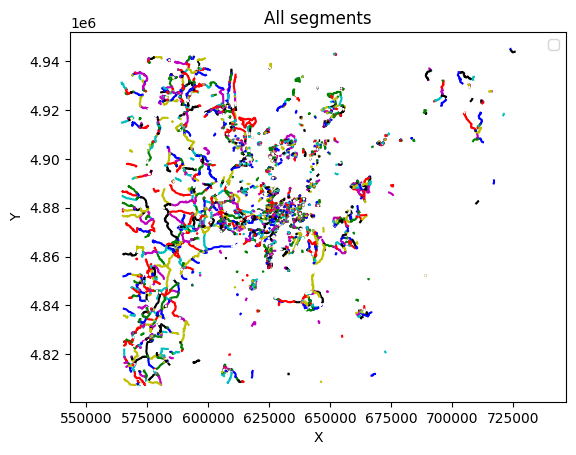

In [10]:
fig, ax = plt.subplots()

rendered_segments = []
for s in segment_geometries:
    rendered_segment = projections.project_line_to_meters(s)
    rendered_segments.append(rendered_segment)

for i, s in enumerate(rendered_segments):
    x, y = s.xy
    ax.plot(x, y, color=standard_colors[i % len(standard_colors)])

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("All segments")
ax.legend()

# Set equal aspect ratio
plt.axis('equal')

# Show the plot
plt.show()

In [11]:
import os
import pickle

filename = os.path.join("data", 'all_trail_segments.pickle')

with open(filename, 'wb') as f:
    pickle.dump(all_segments, f)

print("Saved all trail segments")

Saved all trail segments
